# Libs

In [1]:
import time
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from bernstein_flow.activations import get_thetas_constrain_fn
from bernstein_flow.bijectors import BernsteinBijectorLinearExtrapolate
from bernstein_flow.distributions import BernsteinFlow
from bernstein_flow.util.visualization import plot_flow
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras as K
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability.python.internal import (
    dtype_util,
    prefer_static,
    tensor_util,
)
from tqdm.notebook import tqdm, trange

2023-03-29 16:57:30.913890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-29 16:57:30.913930: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Seed

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Functions

In [3]:
# Construct and fit model.
# @tf.function
def fit_distribution(
    model,
    learning_rate=0.001,
    lr_patience=5,
    **kwds,
):
    set_seed(1)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=lambda y, dist: -dist.log_prob(y),
    )

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=lr_patience,
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3 * lr_patience,
            restore_best_weights=True,
        ),
        tf.keras.callbacks.TerminateOnNaN(),
    ]

    return model.fit(
        shuffle=True,
        callbacks=callbacks,
        **kwds,
    )

In [4]:
def get_nll(dist, y):
    return lambda pv: -dist(pv).log_prob(y)

In [5]:
def get_nll(dist, pv, y):
    return lambda: -dist(pv).log_prob(y)

In [6]:
def plot_samples(dist, train_data, seed=1):
    N = train_data.shape[0]
    # Use the fitted distribution.
    start = time.time()
    samples = dist.sample(N, seed=seed)
    end = time.time()
    print(f"sampling took {end-start} seconds.")

    df1 = pd.DataFrame(columns=["x1", "x2"], data=train_data)
    df1 = df1.assign(source="data")

    df2 = pd.DataFrame(columns=["x1", "x2"], data=samples.numpy())
    df2 = df2.assign(source="model")

    df = df1.append(df2, ignore_index=True)

    # sns.jointplot(data=df, x='x1', y='x2', hue='source', kind='kde')
    g = sns.jointplot(data=df, x="x1", y="x2", hue="source", alpha=0.5)
    g.plot_joint(sns.kdeplot)
    # g.plot_marginals(sns.rugplot, height=-.15)

# Data

In [7]:
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
X, Y = noisy_moons
data = MinMaxScaler().fit_transform(X)

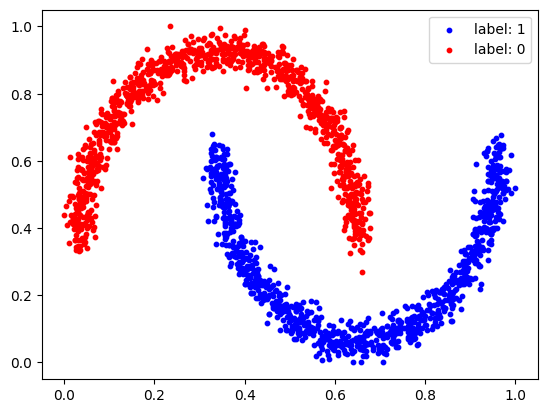

In [8]:
# Plot with labels
y_label = Y.astype(bool)
X_train, Y_train = data[..., 0], data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color="blue")
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color="red")
plt.legend(["label: 1", "label: 0"])

# Compare Models

In [9]:
results={}

the model-based density function for $Y$ is therefore

$f_{\boldsymbol{Y}}(\boldsymbol{y})=\prod_{j=1}^{J} \phi_{0,1}\left(\lambda_{j 1} \tilde{h}_{1}\left(y_{1}\right)+\ldots+\lambda_{j, j-1} \tilde{h}_{j-1}\left(y_{j-1}\right)+\tilde{h}_{j}\left(y_{j}\right)\right) \frac{\partial \tilde{h}_{j}\left(y_{j}\right)}{\partial y_{j}}$

Summarising the model's specifications, our multivariate transformation model is characterised by a set of marginal transformations $\tilde{h}_{j}\left(y_{j}\right), j=1, \ldots, J$, each applying to only a single component of the vector $\boldsymbol{Y}$, and by a lower triangular $(J \times J)$ matrix of transformation coefficients

$\boldsymbol{\Lambda}=\left(\begin{array}{ccccc}1 & & & & 0 \\ \lambda_{21} & 1 & & & \\ \lambda_{31} & \lambda_{32} & 1 & & \\ \vdots & \vdots & & \ddots & \\ \lambda_{J 1} & \lambda_{J 2} & \ldots & \lambda_{J, J-1} & 1\end{array}\right)$

For the transformation functions $\tilde{h}_{j}$, the explicit representation
$$
\tilde{h}_{j}\left(Y_{j}\right)=\Phi_{0, \sigma_{j}^{2}}^{-1}\left(F_{j}\left(Y_{j}\right)\right)=\tilde{Z}_{j}
$$
is obtained, where $F_{j}(\cdot)$ is the univariate marginal CDF of $Y_{j}$. In summary,
$$
\begin{aligned}
\mathbb{P}(\boldsymbol{Y} \leq \boldsymbol{y}) &=\mathbb{P}(\tilde{\boldsymbol{Z}} \leq \tilde{\boldsymbol{z}})=\Phi_{0, \boldsymbol{\Sigma}}(\tilde{\boldsymbol{z}})=\Phi_{\mathbf{0}, \boldsymbol{\Sigma}}\left[\Phi_{0, \sigma_{1}^{2}}^{-1}\left\{F_{1}\left(y_{1}\right)\right\}, \ldots, \Phi_{0, \sigma_{J}^{2}}^{-1}\left\{F_{J}\left(y_{J}\right)\right\}\right] \\
&=\Phi_{0, \boldsymbol{\Sigma}}\left(\tilde{h}_{1}\left(y_{1}\right), \ldots, \tilde{h}_{J}\left(y_{J}\right)\right)
\end{aligned}
$$
and therefore the CDF of $\boldsymbol{Y}$ has exactly the same structure as a Gaussian copula, except that our representation relies on a different parameterisation of $\boldsymbol{\Sigma}$ through $\boldsymbol{\Sigma}=\Lambda^{-1} \Lambda^{-\top}$.

In [10]:
dims = 2

## Multivariate Normal

In [11]:
def get_multivariate_normal_lambda(dims):
    def lmbd(pv):
        loc = pv[..., :dims]
        scale_tril = tfp.bijectors.FillScaleTriL()(pv[..., dims:])
        mv_normal = tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril)
        return mv_normal

    return lmbd

In [21]:
pv_shape = dims + np.sum(np.arange(dims + 1))

epochs = 500
seed = 1
initial_learning = 0.1

set_seed(seed)

opt = tf.optimizers.Adam(learning_rate)

pv = tf.Variable(tf.random.normal([pv_shape], dtype=tf.float32), trainable=True)
mn = get_multivariate_normal_lambda(dims)

it = trange(epochs)
for i in it:
    #for batch in tqdm(data.reshape((-1, batch_size, 2)), leave=False):
    nll = get_nll(mn, pv, data)
    opt.minimize(nll, var_list=[pv])
    it.set_postfix(loss=nll().numpy().mean(), lr=opt.learning_rate.numpy())
results["Multivariate Normal"] = nll().numpy().mean()

  0%|          | 0/500 [00:00<?, ?it/s]

In [22]:
pv

<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([ 0.49706554,  0.4952955 , -1.2337488 , -0.12744962, -1.1766198 ],
      dtype=float32)>

sampling took 0.010405778884887695 seconds.


/tmp/ipykernel_21755/4153950975.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


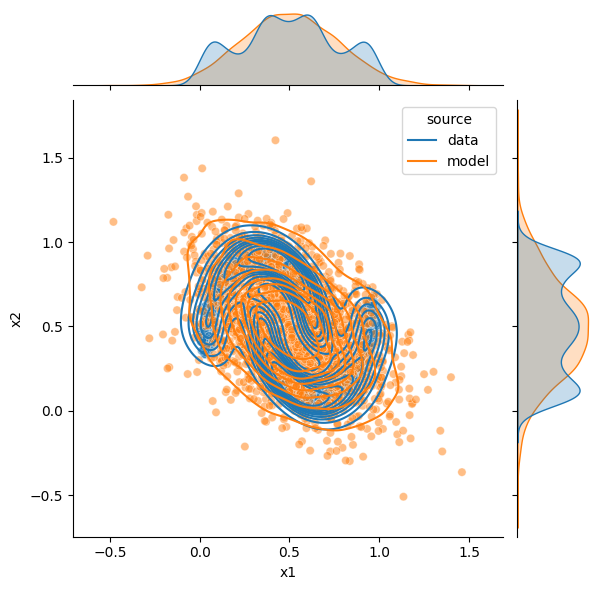

In [23]:
plot_samples(mn(pv), data, seed=1)

## Multivariate Conditional Transformation Models

the model-based density function for $Y$ is therefore

$f_{\boldsymbol{Y}}(\boldsymbol{y})=\prod_{j=1}^{J} \phi_{0,1}\left(\lambda_{j 1} \tilde{h}_{1}\left(y_{1}\right)+\ldots+\lambda_{j, j-1} \tilde{h}_{j-1}\left(y_{j-1}\right)+\tilde{h}_{j}\left(y_{j}\right)\right) \frac{\partial \tilde{h}_{j}\left(y_{j}\right)}{\partial y_{j}}$

Summarising the model's specifications, our multivariate transformation model is characterised by a set of marginal transformations $\tilde{h}_{j}\left(y_{j}\right), j=1, \ldots, J$, each applying to only a single component of the vector $\boldsymbol{Y}$, and by a lower triangular $(J \times J)$ matrix of transformation coefficients

$\boldsymbol{\Lambda}=\left(\begin{array}{ccccc}1 & & & & 0 \\ \lambda_{21} & 1 & & & \\ \lambda_{31} & \lambda_{32} & 1 & & \\ \vdots & \vdots & & \ddots & \\ \lambda_{J 1} & \lambda_{J 2} & \ldots & \lambda_{J, J-1} & 1\end{array}\right)$

For the transformation functions $\tilde{h}_{j}$, the explicit representation
$$
\tilde{h}_{j}\left(Y_{j}\right)=\Phi_{0, \sigma_{j}^{2}}^{-1}\left(F_{j}\left(Y_{j}\right)\right)=\tilde{Z}_{j}
$$
is obtained, where $F_{j}(\cdot)$ is the univariate marginal CDF of $Y_{j}$. In summary,
$$
\begin{aligned}
\mathbb{P}(\boldsymbol{Y} \leq \boldsymbol{y}) &=\mathbb{P}(\tilde{\boldsymbol{Z}} \leq \tilde{\boldsymbol{z}})=\Phi_{0, \boldsymbol{\Sigma}}(\tilde{\boldsymbol{z}})=\Phi_{\mathbf{0}, \boldsymbol{\Sigma}}\left[\Phi_{0, \sigma_{1}^{2}}^{-1}\left\{F_{1}\left(y_{1}\right)\right\}, \ldots, \Phi_{0, \sigma_{J}^{2}}^{-1}\left\{F_{J}\left(y_{J}\right)\right\}\right] \\
&=\Phi_{0, \boldsymbol{\Sigma}}\left(\tilde{h}_{1}\left(y_{1}\right), \ldots, \tilde{h}_{J}\left(y_{J}\right)\right)
\end{aligned}
$$
and therefore the CDF of $\boldsymbol{Y}$ has exactly the same structure as a Gaussian copula, except that our representation relies on a different parameterisation of $\boldsymbol{\Sigma}$ through $\boldsymbol{\Sigma}=\Lambda^{-1} \Lambda^{-\top}$.

In [15]:
def get_mctm_lambda(dims, M, thetas_constrain_fn):
    def lmbd(pv):
        bs = prefer_static.shape(pv)[:-1]
        shape = tf.concat((bs, [dims, M]), 0)

        thetas = thetas_constrain_fn(tf.reshape(pv[..., : M * dims], shape))
        scale_tril = tfp.bijectors.FillScaleTriL()(pv[..., M * dims :])

        mv_normal = tfd.MultivariateNormalTriL(loc=0, scale_tril=scale_tril)

        return tfd.TransformedDistribution(
            distribution=mv_normal,
            bijector=tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas)),
        )

    return lmbd

In [16]:
thetas_constrain_fn = get_thetas_constrain_fn(
    low=-3,
    high=3,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    eps=1e-04,
)

In [25]:
M = 20
pv_shape = dims * M + np.sum(np.arange(dims + 1))

epochs = 500
seed = 1
initial_learning = 0.1

set_seed(seed)

opt = tf.optimizers.Adam(learning_rate)

pv = tf.Variable(tf.random.normal([pv_shape], dtype=tf.float32), trainable=True)
mctm = get_mctm_lambda(dims, M, thetas_constrain_fn)

it = trange(epochs)

idx=np.arange(n_samples)
for i in it:
    #np.random.shuffle(idx)
    #for batch in tqdm(data[idx].reshape((-1, batch_size, 2)), leave=False):
    nll = get_nll(mctm, pv, data)
    opt.minimize(nll, var_list=[pv])
    it.set_postfix(loss=nll().numpy().mean(), lr=opt.learning_rate.numpy())
results["Multivariate Conditional Transformation Models"] = nll().numpy().mean()

  0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
pv

<tf.Variable 'Variable:0' shape=(43,) dtype=float32, numpy=
array([-1.4969367 ,  2.4093459 , -4.491016  , -4.9546747 , -4.7675133 ,
       -3.7486498 , -0.7051583 ,  2.4423707 , -0.58180076, -2.118358  ,
       -2.075501  , -0.865167  ,  2.8154142 , -2.190767  , -3.9477942 ,
       -4.193253  , -3.733667  , -3.578479  ,  2.5851924 , -0.8860322 ,
        1.4510615 ,  3.0613742 , -3.0157945 , -4.077639  , -3.157515  ,
       -0.49852335, -0.68661475, -1.5744385 , -1.2736222 , -0.22021803,
        0.42992935, -0.92541313, -1.933116  , -0.767767  , -0.7217869 ,
       -3.3388383 , -4.0852757 , -2.4879751 ,  3.5302575 ,  2.0743103 ,
        1.1921396 , -0.6267335 ,  1.0670638 ], dtype=float32)>

sampling took 0.22670507431030273 seconds.


/tmp/ipykernel_21755/4153950975.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


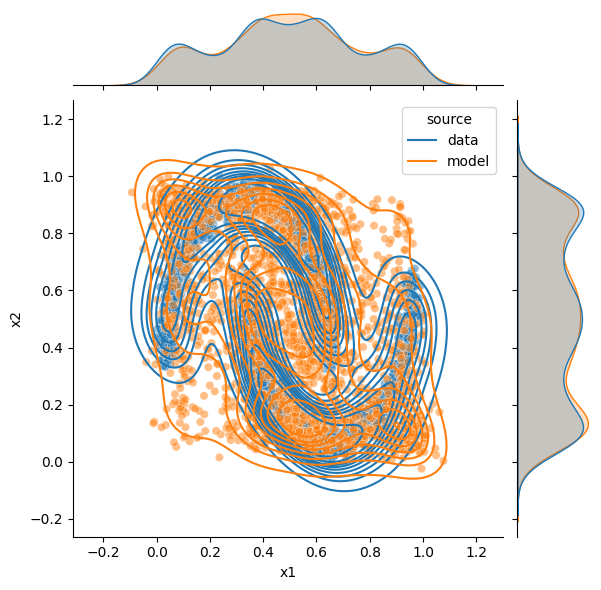

In [27]:
plot_samples(mctm(pv), data, seed=1)

## MADE + BNF
https://github.com/tensorchiefs/bfvi/blob/main/R/multidimensional_script.R

In [29]:
def get_bijector_fn(made, thetas_constrain_fn, **kwds):
    def bijector_fn(x, **kwds):
        with tf.name_scope("bnf_made_bjector"):
            dtype = made.dtype

            pvector = made(x, **kwds)
            thetas = thetas_constrain_fn(pvector)

            return tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas))

    return bijector_fn

In [30]:
M = 50

epochs = 500
seed = 1
initial_learning = 0.1

set_seed(seed)

opt = tf.optimizers.Adam(learning_rate)

made1 = tfb.AutoregressiveNetwork(
    params=M,
    hidden_units=[16, 16],
    event_shape=(dims,),
    activation="relu",
)

thetas_constrain_fn = get_thetas_constrain_fn(
    low=-4,
    high=4,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    #eps=,
)

bijector_fn = get_bijector_fn(made=made1, thetas_constrain_fn=thetas_constrain_fn)

bnf = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(0, 1), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(bijector_fn=bijector_fn),
)

it = trange(epochs)
for i in it:
    nll = lambda: -bnf.log_prob(data)
    opt.minimize(nll, var_list=[made1.trainable_variables])
    it.set_postfix(loss=nll().numpy().mean(), lr=opt.learning_rate.numpy())
results["MADE + MCTM"] = nll().numpy().mean()

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
#opt1 = tf.optimizers.Adam(0.01)
#it = trange(epochs)
#for i in it:
#    nll = lambda: -bnf.log_prob(data)
#    opt1.minimize(nll, var_list=[made1.trainable_variables])
#    it.set_postfix(loss=nll().numpy().mean(), lr=opt1.learning_rate.numpy())
##results["MADE + MCTM"] = nll().numpy().mean()

sampling took 0.3740866184234619 seconds.


/tmp/ipykernel_21755/4153950975.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


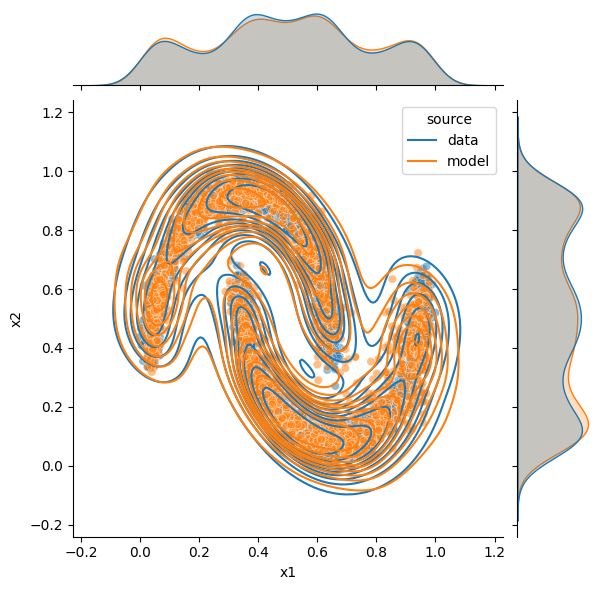

In [31]:
plot_samples(bnf, data, seed=3)

# Results

In [32]:
pd.DataFrame.from_dict(results, orient='index')

,0
Multivariate Normal,0.159700
Multivariate Conditional Transformation Models,-0.199717
MADE + MCTM,-1.250422
